In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader

from pssl.architecture import MLP
from pssl.losses import (
    Dirichlet,
    graph_Laplacian,
    invariance_to_gaussian_perturbations,
    ortho_reg,
    ortho_reg_contrastive,
)
from pssl.datasets.spherical import (
    spherical_harmonic,
    spherical_eigenvalues,
    meshgrid_3d,
)

In [3]:
n = 100
nb_epochs = 5000
k = 16
kwargs = {'dtype': torch.float32, 'device': 'cpu'}

X, Y, Z = meshgrid_3d(100, **kwargs)
x_test = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=-1)

net = MLP([3, 200, 200, 2000, k], layer_norm='none', **kwargs)

In [4]:
eig_thres = 100
optimizer = optim.SGD(
    net.parameters(), lr=1e-3, momentum=.5, weight_decay=0,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, nb_epochs / 3, gamma=.3
)

for i in range(nb_epochs):
    x = torch.randn(n, 3, **kwargs)
    x /= torch.norm(x, dim=1, keepdim=True)

    optimizer.zero_grad(set_to_none=True)
    x.requires_grad = True

    # Objective computation
    loss = Dirichlet(net, x)
    reg = ortho_reg_contrastive(net(x))
    obj = 2 * loss / eig_thres + reg
    obj.backward()

    # Gradient step
    optimizer.step()
    if scheduler is not None:
        scheduler.step()


    if i % 100 == 0:
        print(f"Epochs: {i}, loss: {loss.item()}, reg: {reg.item()}, obj: {obj.item()}")

Epochs: 0, loss: 0.0005233807605691254, reg: 15.953239440917969, obj: 15.95324993133545
Epochs: 100, loss: 0.0024253344163298607, reg: 14.975713729858398, obj: 14.975762367248535
Epochs: 200, loss: 0.0037712291814386845, reg: 14.92446517944336, obj: 14.924540519714355
Epochs: 300, loss: 0.012041033245623112, reg: 14.623053550720215, obj: 14.623294830322266
Epochs: 400, loss: 0.06325341016054153, reg: 13.713471412658691, obj: 13.714736938476562
Epochs: 500, loss: 0.104072205722332, reg: 12.810259819030762, obj: 12.812341690063477
Epochs: 600, loss: 0.13224005699157715, reg: 12.159306526184082, obj: 12.161951065063477
Epochs: 700, loss: 0.1518852859735489, reg: 12.10466194152832, obj: 12.107699394226074
Epochs: 800, loss: 0.1565241664648056, reg: 12.007583618164062, obj: 12.010714530944824
Epochs: 900, loss: 0.15429607033729553, reg: 11.927689552307129, obj: 11.93077564239502
Epochs: 1000, loss: 0.15539586544036865, reg: 12.098115921020508, obj: 12.101223945617676
Epochs: 1100, loss: 0.1

In [5]:
with torch.no_grad():
    phi = net(x_test)
    # phi /= torch.sqrt(torch.mean(phi ** 2, dim=0))
    # phi = phi.numpy()

In [6]:
phi_np = phi.numpy()
cov = phi_np.T @ phi_np
w, v = np.linalg.eigh(cov)

In [7]:
np.abs(cov - (w * v) @ v.T).max()

0.00048828125

In [8]:
phi = phi_np @ v[:, ::-1]
phi /= np.sqrt(np.mean(phi ** 2, axis=0))

IndexError: index 19 is out of bounds for axis 1 with size 16

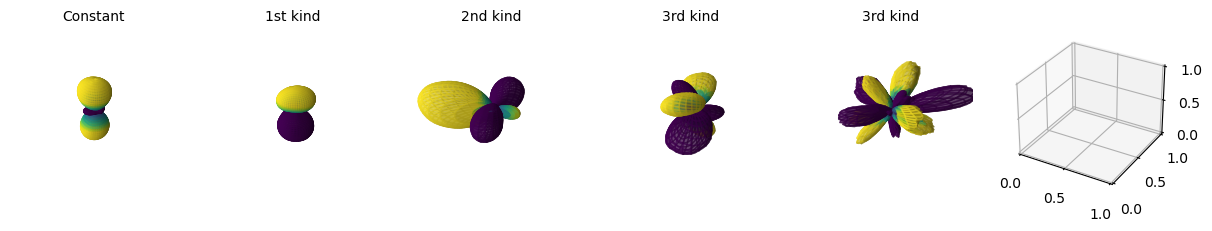

In [9]:
import matplotlib.pyplot as plt

def plot_sphere_surface(ax, X, Y, Z, f, cmap="RdBu", **kwargs):
    cm = plt.get_cmap(cmap)(f.reshape(*X.shape))
    ax.plot_surface(X, Y, Z, facecolors=cm, **kwargs)
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    ax.set_zlim([-0.8, 0.8])
    ax.set_axis_off()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


fig, axes = plt.subplots(1, 6, figsize=(15, 5), subplot_kw={"projection": "3d"})
j = 0
kinds = ["Constant", "1st kind", "2nd kind", "3rd kind", "3rd kind", "4th kind"]
for i in [0, 1, 7, 9, 15, 19]:
    phi_i = phi[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    axes[j].set_title(rf"{kinds[j]}", fontsize=10)
    scale = 2
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1
# fig.savefig("learned_harmonics.jpg", bbox_inches="tight")

In [ ]:
num = 5
phi_true, eigenvalues = spherical_harmonic(x_test, num**2, return_eigenvalues=True, real=True)
phi_true /= torch.sqrt(torch.mean(phi_true ** 2, dim=0))
phi_true = phi_true.numpy()

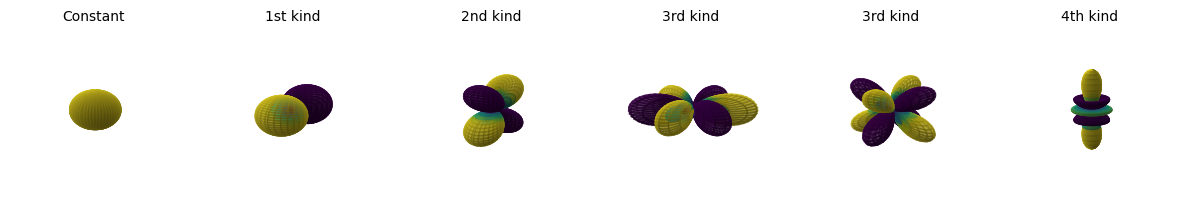

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5), subplot_kw={"projection": "3d"})
j = 0
for i in [0, 1, 7, 9, 10, 20]:
    phi_i = phi_true[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    scale = 2
    axes[j].set_title(f"{kinds[j]}", fontsize=10)
    axes[j].view_init(azim=30, elev=15)
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1